In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from sklearn.metrics import r2_score
from truesight.utils import generate_syntetic_data

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
df = pd.read_csv(f"datasets\M5\sales_train_evaluation.csv")
df.drop(["item_id", "dept_id", "cat_id", "store_id", "state_id"], axis = 1, inplace = True)
df = df.melt(id_vars = "id", var_name = "d", value_name = "y")
df = pd.merge(df, pd.read_csv(f"datasets\M5\calendar.csv")[["date", "d"]], on = "d", how = "left")
df.drop(["d"], axis = 1, inplace = True)
df.rename({"date": "ds", "id": "unique_id"}, axis = 1, inplace = True)
df["ds"] = pd.to_datetime(df["ds"])
df = df.groupby(["unique_id", pd.Grouper(key = "ds", freq = "MS")]).sum().reset_index()
df = df[df['unique_id'].isin(np.random.choice(df['unique_id'].unique(), 2000, replace = False))]

In [3]:
season_length = 12
forecast_horizon = 12

In [4]:
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA
from sklearn.linear_model import LinearRegression
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"),
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AutoARIMA, horizon=forecast_horizon, season_length=season_length),
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = forecast_horizon, 
    season_length = season_length,
    date_freq = "MS", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

100%|██████████| 400/400 [04:02<00:00,  1.65it/s]


Epoch 1/1000
50/50 [==============================] - 17s 265ms/step - loss: 5816.8501 - val_loss: 11507.1250 - lr: 1.0000e-04
Epoch 2/1000
50/50 [==============================] - 13s 257ms/step - loss: 2871.9695 - val_loss: 9811.3984 - lr: 1.0000e-04
Epoch 3/1000
50/50 [==============================] - 13s 256ms/step - loss: 2445.3350 - val_loss: 9078.9697 - lr: 1.0000e-04
Epoch 4/1000
50/50 [==============================] - 13s 254ms/step - loss: 2133.3252 - val_loss: 8901.3428 - lr: 1.0000e-04
Epoch 5/1000
50/50 [==============================] - 13s 254ms/step - loss: 2043.8257 - val_loss: 8318.1670 - lr: 1.0000e-04
Epoch 6/1000
50/50 [==============================] - 13s 254ms/step - loss: 1942.8453 - val_loss: 8184.0386 - lr: 1.0000e-04
Epoch 7/1000
50/50 [==============================] - 13s 253ms/step - loss: 1912.6958 - val_loss: 7893.6968 - lr: 1.0000e-04
Epoch 8/1000
50/50 [==============================] - 13s 258ms/step - loss: 1760.0444 - val_loss: 7372.2939 - lr: 1.

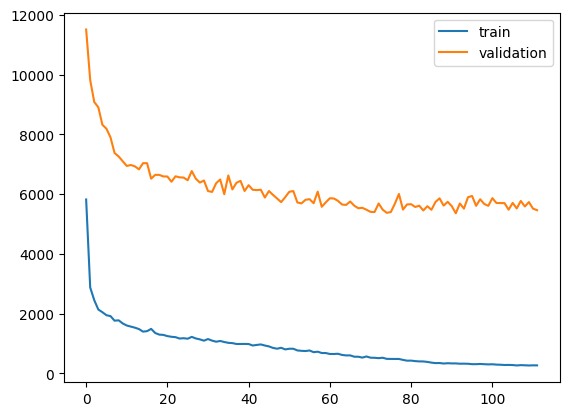

Epoch 1/1000
50/50 [==============================] - 18s 280ms/step - loss: 6027.4458 - val_loss: 11958.5098 - lr: 1.0000e-04
Epoch 2/1000
50/50 [==============================] - 14s 279ms/step - loss: 3572.5503 - val_loss: 10501.6514 - lr: 1.0000e-04
Epoch 3/1000
50/50 [==============================] - 14s 274ms/step - loss: 3243.7676 - val_loss: 10234.3682 - lr: 1.0000e-04
Epoch 4/1000
50/50 [==============================] - 13s 269ms/step - loss: 3088.2905 - val_loss: 9781.9160 - lr: 1.0000e-04
Epoch 5/1000
50/50 [==============================] - 13s 268ms/step - loss: 3002.9333 - val_loss: 9467.5420 - lr: 1.0000e-04
Epoch 6/1000
50/50 [==============================] - 13s 266ms/step - loss: 2817.2788 - val_loss: 9034.7061 - lr: 1.0000e-04
Epoch 7/1000
50/50 [==============================] - 13s 268ms/step - loss: 2193.8823 - val_loss: 8062.6152 - lr: 1.0000e-04
Epoch 8/1000
50/50 [==============================] - 14s 282ms/step - loss: 1931.2622 - val_loss: 7699.9126 - lr: 

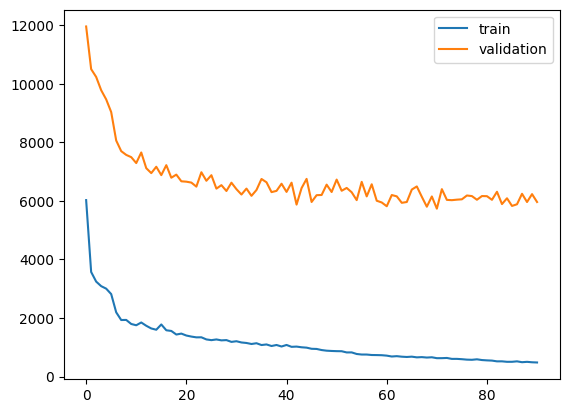

In [5]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10, verbose = False),
]

if True:
    models_nocov = models[-1:]
    X_train_nocov = X_train[-1:]
    X_val_nocov = X_val[-1:]

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    ts_nocov = TrueSight(models_nocov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_nocov.compile(optimizer=optimizer, loss='mse')

    ts_nocov.fit(
        x = X_train_nocov, y = Y_train,
        validation_data = [X_val_nocov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_nocov.plot_training_history()
    ts_nocov.save_weights('nocov.h5')

    models_wcov = models.copy()
    X_train_wcov = X_train.copy()
    X_val_wcov = X_val.copy()

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    ts_wcov= TrueSight(models_wcov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_wcov.compile(optimizer=optimizer, loss='mse')

    ts_wcov.fit(
        x = X_train_wcov, y = Y_train,
        validation_data = [X_val_wcov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_wcov.plot_training_history()
    ts_wcov.save_weights('ts_wcov.h5')

    yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
    yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)
else:
    yhat_nocov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_nocov.npy')
    yhat_wcov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_wcov.npy')

In [6]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.635949
mape        0.906003
mse      6032.042383
rmse       24.907961
mae        21.524541
dtype: float64

In [7]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.631802
mape        0.857080
mse      5424.136282
rmse       24.713039
mae        21.181338
dtype: float64

In [8]:
r2_score(Y_val, yhat_wcov.mean(axis=0))

0.5761706563556722

In [9]:
r2_score(Y_val, yhat_nocov.mean(axis=0))

0.6196324525689844

In [10]:
group_a = r2_score(Y_val.T, yhat_wcov.mean(axis=0).T, multioutput='raw_values')
group_b = r2_score(Y_val.T, yhat_nocov.mean(axis=0).T, multioutput='raw_values')

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.8276424380735107
P-Value: 0.40812045891399185


In [11]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.15370560952978193
P-Value: 0.8778807220922604


In [12]:
group_a = mape(Y_val, yhat_wcov.mean(axis=0))
group_b = mape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.7417263519792812
P-Value: 0.45847138491749007


In [13]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.09929376787905456
P-Value: 0.920929963839502


In [14]:
group_a = rmse(Y_val, yhat_wcov.mean(axis=0))
group_b = rmse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.03850494410144214
P-Value: 0.9692947200439597


In [15]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.0724677054956767
P-Value: 0.9422478639797054
